<a href="https://colab.research.google.com/github/xdxdhh/kernel_pca_py/blob/main/kernel_pca_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kernel PCA

## The Goal



The goal of this project was to transform clusters that ae not linearly separable in 2 dimensions into new coordinates, where they can be separated by lines. To do so, I decided to implement Kernel version of standard PCA, as it should be able to detect non-linear relations pretty well.

## Dataset

**Source:**
Dataset Clustering Excercises from Kaggle\
https://www.kaggle.com/datasets/joonasyoon/clustering-exercises

This is a group of 25 different datasets with 10000 points each, I used just a few of them.




<img src="https://i.imgur.com/ZUX61cD.png">





In [ ]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

#tady si vybrat nejake datasety z tech nahore a nacist je zvlast do jejich own X a y 
# Prepare data 
url_dart = 'https://raw.githubusercontent.com/xdxdhh/data_for_colab/main/dart.csv'
url_dart2 = 'https://raw.githubusercontent.com/xdxdhh/data_for_colab/main/dart2.csv'
#url = 'https://raw.githubusercontent.com/xdxdhh/data_for_colab/main/chrome.csv'
#url = 'https://raw.githubusercontent.com/xdxdhh/data_for_colab/main/basic3.csv'
#url = 'https://raw.githubusercontent.com/xdxdhh/data_for_colab/main/wave.csv'
#url = 'https://raw.githubusercontent.com/xdxdhh/data_for_colab/main/un.csv'
url_spiral2 = 'https://raw.githubusercontent.com/xdxdhh/data_for_colab/main/spiral2.csv'
url_face = 'https://raw.githubusercontent.com/xdxdhh/data_for_colab/main/face.csv'

dataset_dart = pd.read_csv(url_dart)
y_dart = np.array(dataset_dart['color'][0:300])
X_dart = np.array(dataset_dart[['x', 'y']][0:300])

dataset_dart2 = pd.read_csv(url_dart2)
y_dart2 = np.array(dataset_dart2['color'][0:300])
X_dart2 = np.array(dataset_dart2[['x', 'y']][0:300]) 

dataset_spiral2 = pd.read_csv(url_spiral2)
y_spiral2 = np.array(dataset_spiral2['color'][0:300])
X_spiral2 = np.array(dataset_spiral2[['x', 'y']][0:300]) 

dataset_face = pd.read_csv(url_face)
y_face = np.array(dataset_face['color'][0:300])
X_face = np.array(dataset_face[['x', 'y']][0:300]) 


## Kernel PCA Principle


Kernel PCA can be used to project linearly inseparable data to higher dimension, where it becomes linearly separable.


Let's asumme we have data $$ X = [x_1, x_2, ... x_n], $$

The key is to obtain so called **Kernel Matrix**, which terms can be obtained using **kernel function κ**: $$ K[i,j] = \kappa(x_i,x_j) $$ This matrix is symmetric of dimension n.


One of the most widely spread kernel functions is **RBF Kernel** defined as:
$$ κ(x_i,x_j) = exp(\frac{-||x_i-x_j||^2}{2σ^2})$$ where ||.|| denotes Euclidean norm and σ is a free parameter.

In order to be used for PCA, Kernel matrix must be centered. This can be done as:
$$ K = K - \frac{1}{l}jj'K - \frac{1}{l}Kjj' + \frac{1}{l^2}(j'Kj)jj'$$

Afterwards, eigenvalues **λ** and eigenvectors **v** of K are calculated and first d eigenvectors and eigevalues are selected, as in standard PCA.

To project our original n dimensional data into d dimensions we use dot product between X and vector **α**, where **α** is given as:
$$ \alpha_j = \frac{v_j}{\sqrt{λ_j}} , j = 1,....d $$


## Implementation

In [ ]:
#imports
import numpy.typing as types
import numpy as np
from sklearn.preprocessing import StandardScaler


class Kernel_PCA:

  def __init__(self, n_dimensions : int, sigma : float): #how many dimensions we want to have after PCA , sigma - RBF param
    self.n_dimensions = n_dimensions
    self.sigma = sigma

  def norm_L2(self, x : types.ArrayLike) -> float: #return L2 norm of vector 
    return np.sqrt(sum((np.abs(x_i))**2 for x_i in x))

  def kernel_rbf(self, x : types.ArrayLike, y : types.ArrayLike, sigma : float) -> float: 
    return np.exp(-(self.norm_L2(x-y))**2/(2*sigma**2))

  def create_kernel_matrix(self, X):
    n = np.shape(X)[0] #number of data points
    K = np.zeros((n, n))

    #create kernel matrix
    for i in range(0, n):
        for j in range(0, n):
            K[i,j] = self.kernel_rbf(X[i], X[j], self.sigma) 

    #center kernel matrix
    j = np.ones(n)
    K = K - (1/n)*(j*j.T)*K - (1/n)*K*(j*j.T) + 1/(n^2) * (j*j.T) * K * (j*j.T)
    
    #alternatively:
    #J = np.ones((n,n)) / n
    #K = K - np.dot(J, K) - np.dot(K, J) + J @ K @ J

    return K

  def fit(self, X): #fits the data and returns new coordinates

    X = StandardScaler().fit_transform(X)
    K = self.create_kernel_matrix(X)
    #get eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(K) #eigh -> specialized for symmetric matrices
    #sort eigenvectors and get first n eigenvalues and eigenvectors
    eigenvectors = eigenvectors.T    
    idxs = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idxs][0:self.n_dimensions]
    eigenvectors = eigenvectors[idxs][0:self.n_dimensions]

    #get alpha
    alpha = np.zeros((np.shape(eigenvectors)))
    for j in range(0, self.n_dimensions):
        alpha[j] = np.dot(1/np.sqrt(eigenvalues[j]), eigenvectors[j])

    X_new = np.dot(alpha,K) 
    return X_new.T


## Testing and comparing with standard PCA

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#colors = ['orange', 'red', 'purple', 'brown', 'yellow', 'pink']
colors = ['gold', 'purple', 'gray', 'lightskyblue', 'yellow', 'pink']


def compare_PCA(X, y, sigma):
  kpca = Kernel_PCA(2, sigma)
  X_new = kpca.fit(X)

  #stock PCA from sklearn
  pca = PCA(n_components=2)
  Y = pca.fit_transform(X)


  fig,ax = plt.subplots(1,3, figsize=(25,7))
  for z in range(0,np.shape(X)[0]):
      ax[0].scatter(X[z,0], X[z,1], c=colors[y[z]])
      ax[0].set_title('Original Data')
      ax[0].set_xlabel('X')
      ax[0].set_ylabel('Y')

      ax[1].scatter(X_new[z,0], X_new[z,1], c=colors[y[z]])
      ax[1].set_title('Data after Kernel PCA')
      ax[1].set_xlabel('Component 1')
      ax[1].set_ylabel('Component 2')


      ax[2].scatter(Y[z,0], Y[z,1], c=colors[y[z]])
      ax[2].set_title('Data after standard PCA')
      ax[2].set_xlabel('Component 1')
      ax[2].set_ylabel('Component 2')


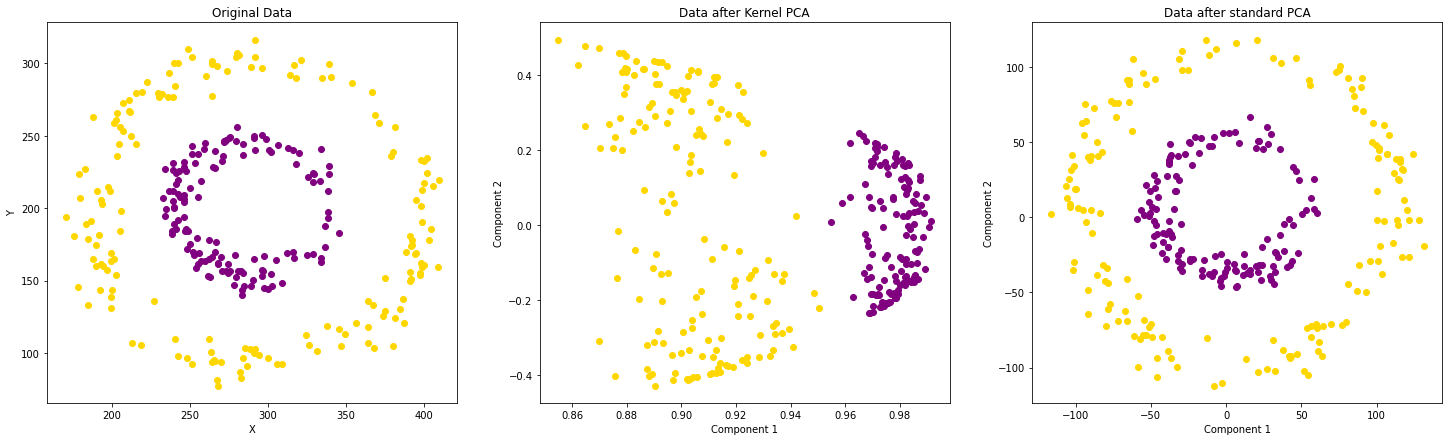

In [ ]:
compare_PCA(X_dart, y_dart, np.sqrt(15))

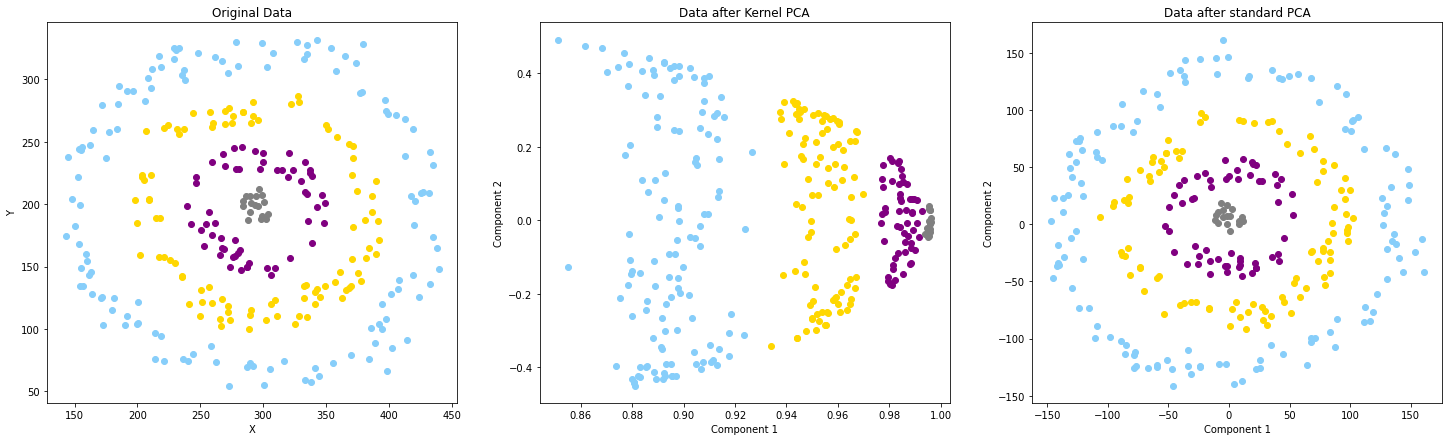

In [ ]:
compare_PCA(X_dart2, y_dart2, np.sqrt(15))

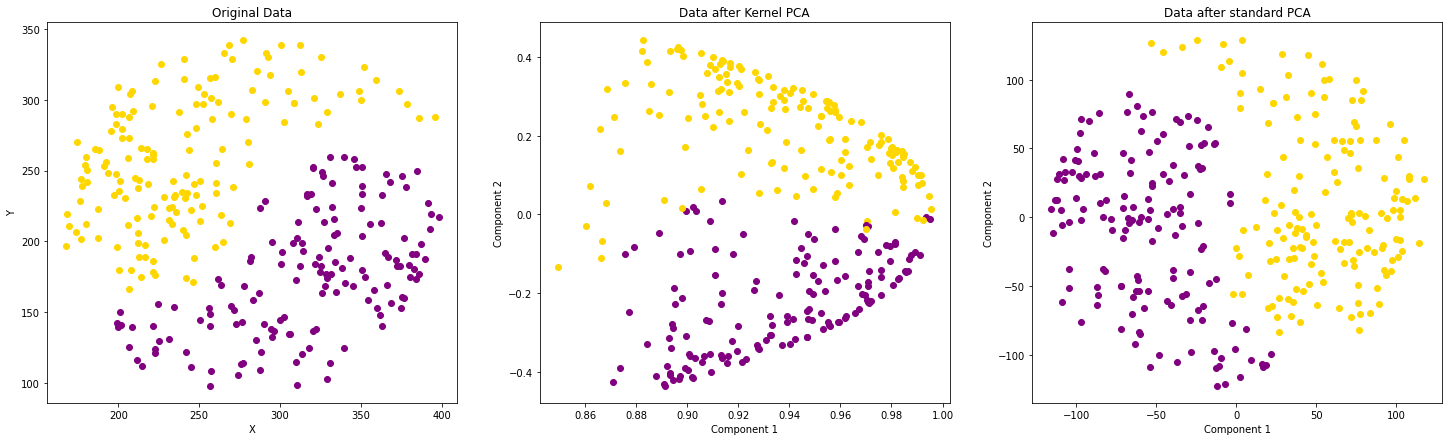

In [ ]:
compare_PCA(X_spiral2, y_spiral2, np.sqrt(15))

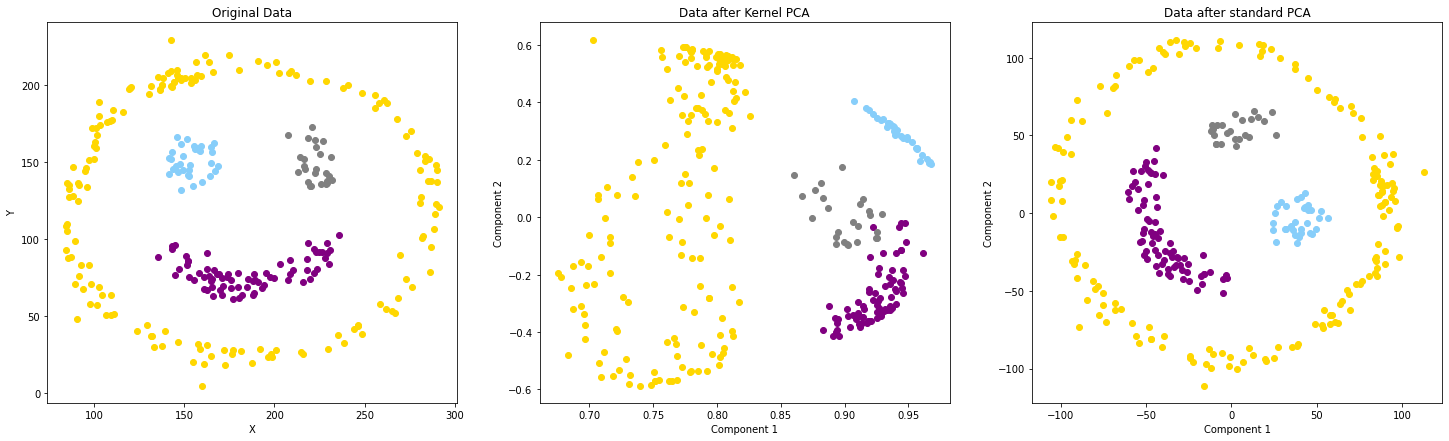

In [ ]:
compare_PCA(X_face, y_face, np.sqrt(5))

## Importance of σ

Tuning σ is the most difficult task, there is no universal σ for every dataset and just a slight modification of its value can change the result fundamentally.

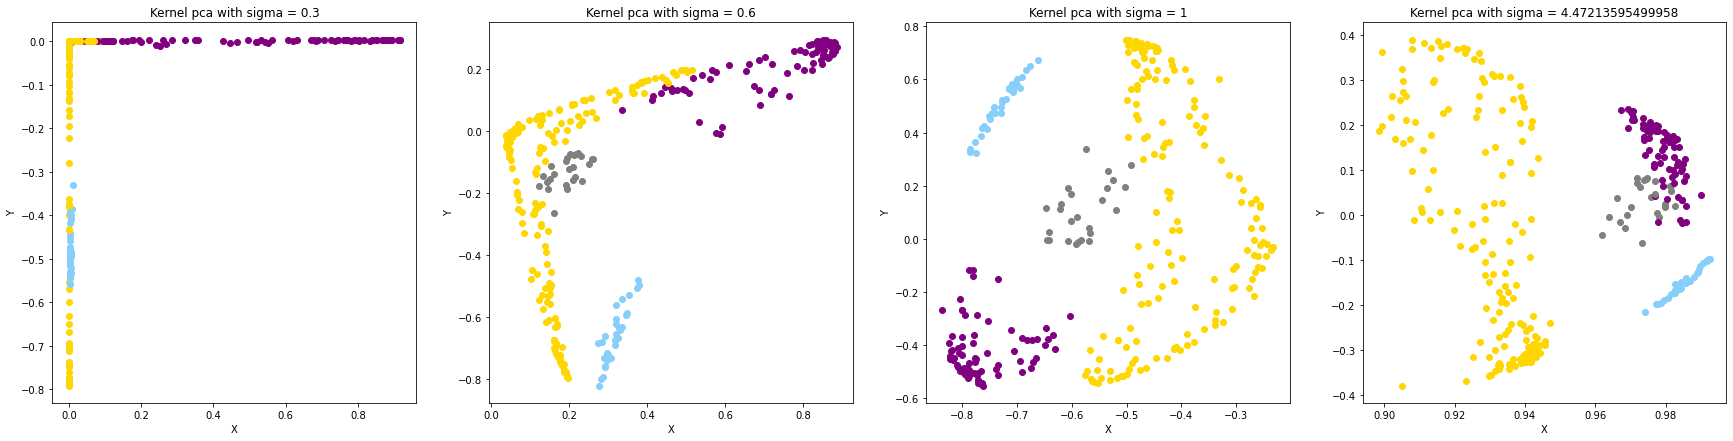

In [ ]:
different_sigma = [0.3, 0.6, 1, np.sqrt(20)]

colors = ['gold', 'purple', 'gray', 'lightskyblue', 'yellow', 'pink']

fig,ax = plt.subplots(1,4, figsize=(30,7))

for i, sigma in enumerate(different_sigma):

  kpca = Kernel_PCA(2, sigma)
  X_new = kpca.fit(X_face)

  for z in range(0,np.shape(X_new)[0]):
      ax[i].scatter(X_new[z,0], X_new[z,1], c=colors[y_face[z]])
      ax[i].set_title(f'Kernel pca with sigma = {sigma}')
      ax[i].set_xlabel('X')
      ax[i].set_ylabel('Y')
